In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from LIM.neural_networks import utilities as ut
from LIM.neural_networks.models import LIM_class
import scipy.linalg as linalg

In [2]:

data_ts = xr.open_dataset("./neural_networks/raw_data/ts_Amon_CESM2_piControl_r1i1p1f1.nc")["ts"]
data_zos = xr.open_dataset("./neural_networks/raw_data/zos_Amon_CESM2_piControl_r1i1p1f1.nc")["zos"]
#data_old = xr.open_dataset("./data/ssta_1950_2021.nc")["ssta"]
mask = xr.open_dataset("./neural_networks/raw_data/sftlf_fx_CESM2_historical_r1i1p1f1.nc")["sftlf"]

#14400 orginial size
data_ts = data_ts[:, :, :]

data_zos = ut.reshape_xarray(data_zos)
data_ts = ut.reshape_xarray(data_ts)

data_ts = ut.apply_mask(ut.reshape_xarray(mask), data_ts)
data_zos = ut.apply_mask(ut.reshape_xarray(mask), data_zos)

data_anomalies_ts = ut.calculate_monthly_anomalies(data_ts)
data_anomalies_zos = ut.calculate_monthly_anomalies(data_zos)

data_cropped_ts =ut.crop_xarray(130, -70, data_anomalies_ts)
data_cropped_zos =ut.crop_xarray(130, -70, data_anomalies_zos)

data_cropped_ts =ut.crop_xarray_lat(data_cropped_ts)
data_cropped_zos =ut.crop_xarray_lat(data_cropped_zos)

#data_cropped =ut.crop_xarray(data_anomalies)

pca_20_ts = ut.SpatioTemporalPCA(data_cropped_ts, n_components=20)
eof_20_ts = pca_20_ts.eofs()
pc_20_ts = pca_20_ts.principal_components()

pca_10_zos = ut.SpatioTemporalPCA(data_cropped_zos, n_components=10)
eof_10_zos = pca_10_zos.eofs()
pc_10_zos = pca_10_zos.principal_components()

In [3]:
filename = "combined_data_piControl"
data_type = "np"
ut.concatenate_and_save_data(pc_20_ts, pc_10_zos, data_type, filename)


torch.Size([20, 14400])
torch.Size([10, 14400])
torch.Size([30, 14400])


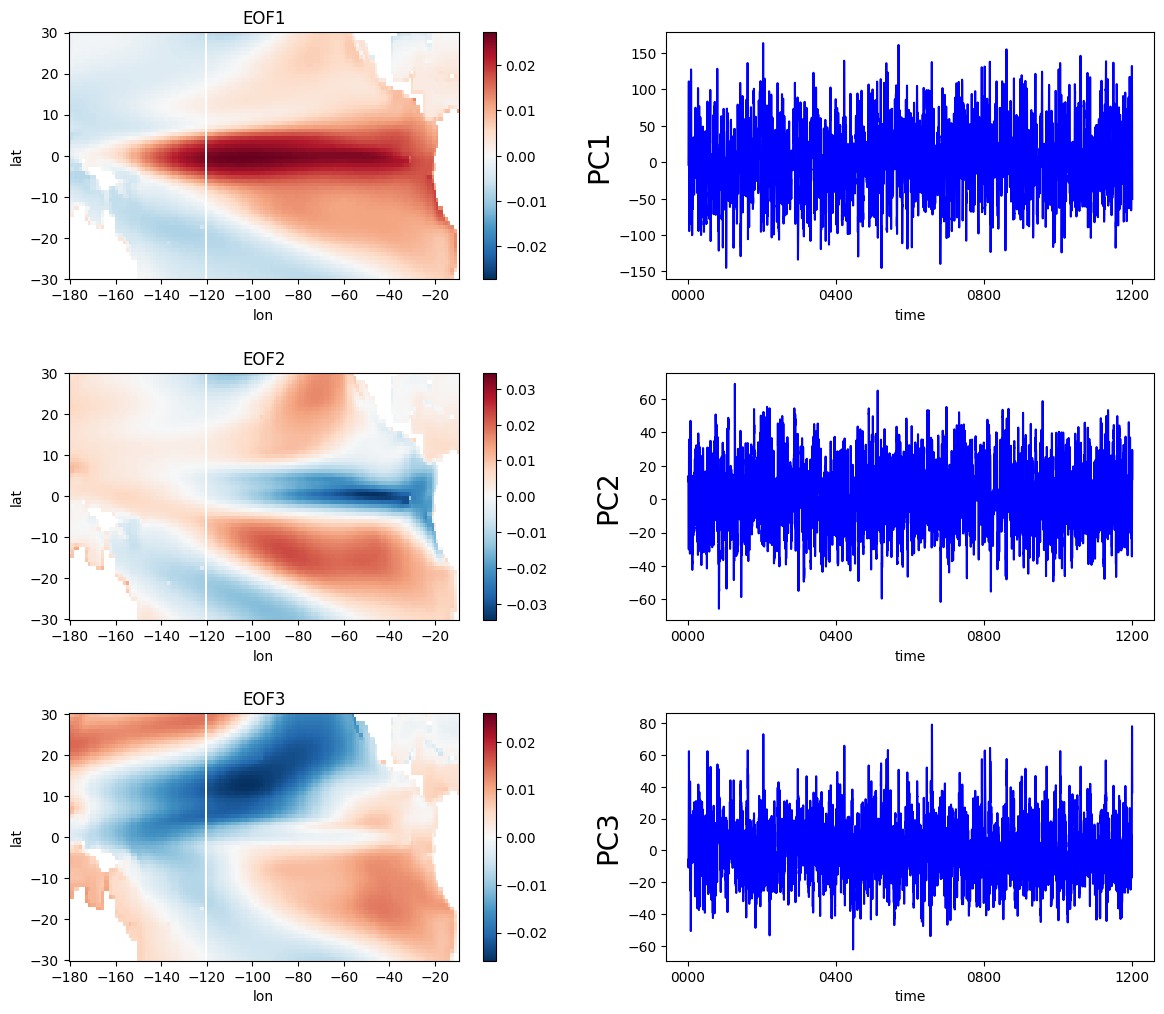

In [4]:
# Set the number of plots to 2
number_of_plots = 3

# Create the figure and axes objects
fig = plt.figure(figsize=(2 * 6, 3.5 * number_of_plots))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    ax = fig.add_subplot(number_of_plots, 2, 2*i+1)
    eof_20_ts[i].plot(ax=ax, cmap="RdBu_r")
    ax.set_title(f"EOF{i+1}")
    ax = fig.add_subplot(number_of_plots, 2, 2*i + 2)
    pc_20_ts.isel(eof=i).plot(ax=ax, color="blue")
    ax.set_ylabel(f"PC{i+1}", fontsize=20)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
fig.savefig('./plots/svg/EOFS_timeseries_piControl.svg', format='svg')
fig.savefig('./plots/png/EOFS_timeseries_piControl.png', format='png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


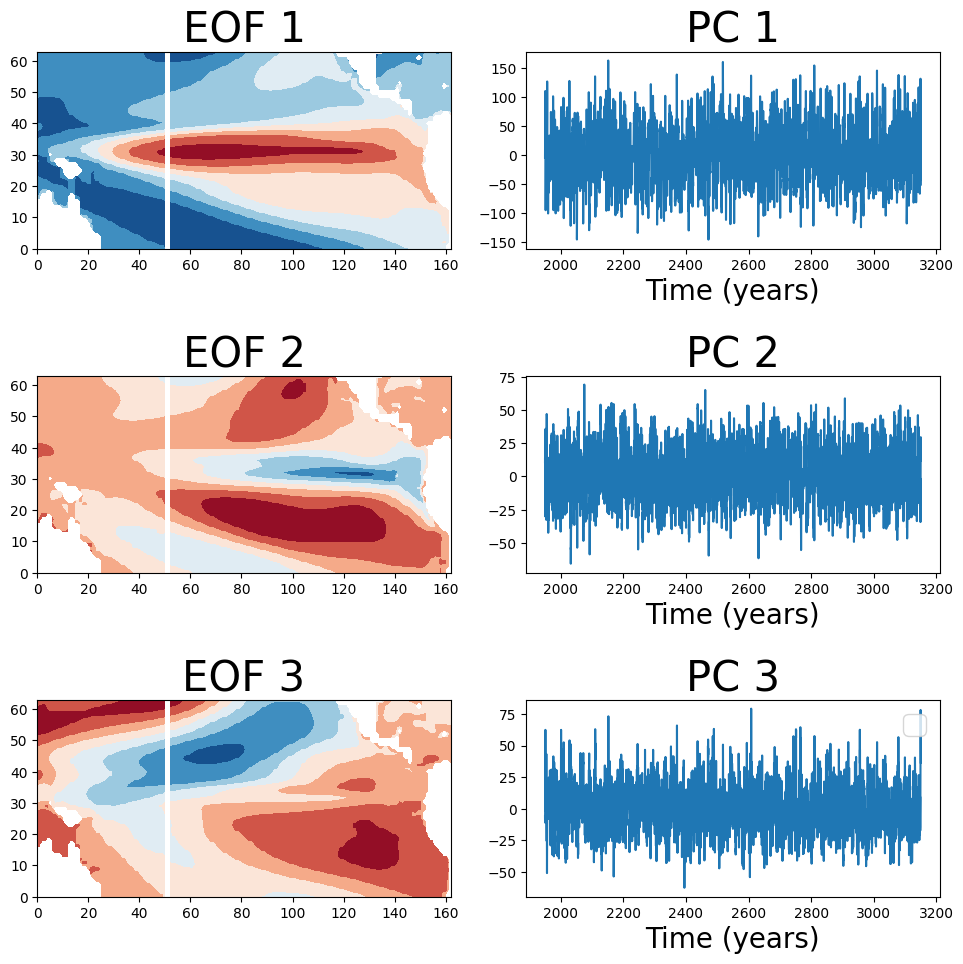

In [5]:
# Set the number of plots to 2
number_of_plots = 3

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(10, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=30)
    axs[i,0].contourf(eof_20_ts[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=30)
    # Define time variable
    time = np.arange(len(pc_20_ts[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_20_ts[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=20)

plt.legend(loc="upper right", fontsize=20)
# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
fig.savefig('./plots/svg/EOFS_timeseries_RdBu_r_piControl.svg', format='svg')
fig.savefig('./plots/png/EOFS_timeseries_RdBu_r_piControl.png', format='png')
plt.show()

In [6]:
# Create training and test data
data = pc_20_ts
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

# Creating an example LIM object
tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)

Covariance matrix has negative values!


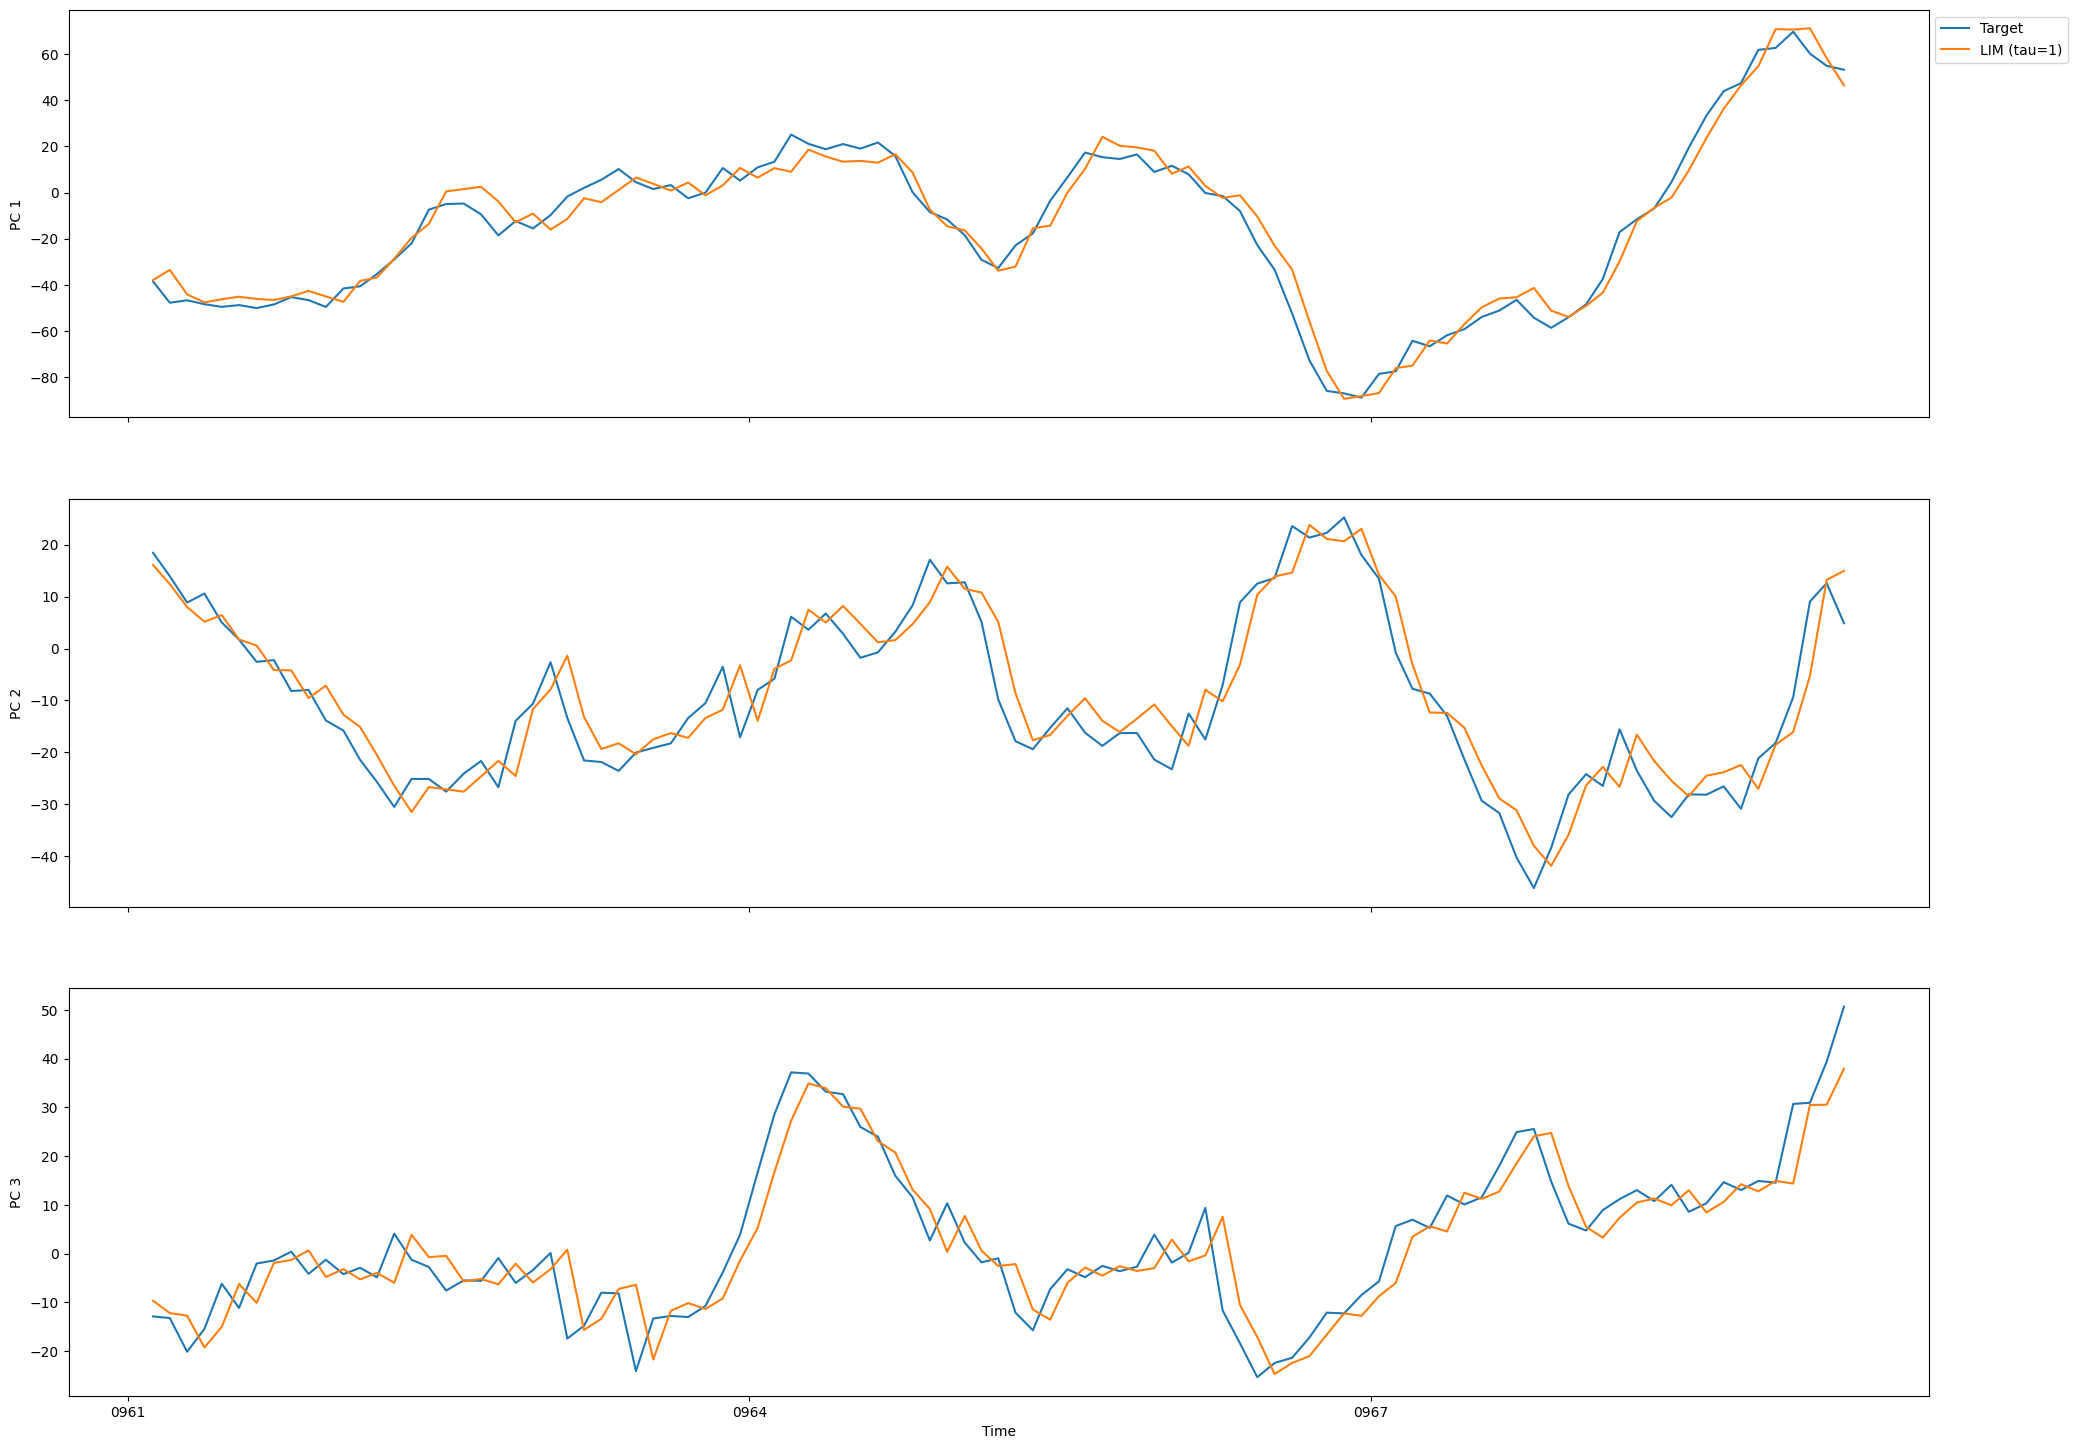

In [7]:
# Forecasting

# Define lag
lag = 1

# Get input data
x_target = data_test.isel(time=np.arange(0, 100))
times = x_target['time']
x = x_target.data


#forecast_output = model.forecast(x, [0, 1,2,3, 4, 5, 6])
#forecast_output = forecast_output[lag, : , :]
forecast_output = model.forecast_mean(x, lag=lag)


# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(24, 18), sharex=True)

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], forecast_output[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {idx_components[i]+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')
fig.savefig('./plots/svg/mean_forecasting_PC_piControl.svg', format='svg')
fig.savefig('./plots/png/mean_forecasting_PC_piControl.png', format='png')
plt.show()

(20, 1001)


ValueError: x and y must have same first dimension, but have shapes (10001,) and (1001,)

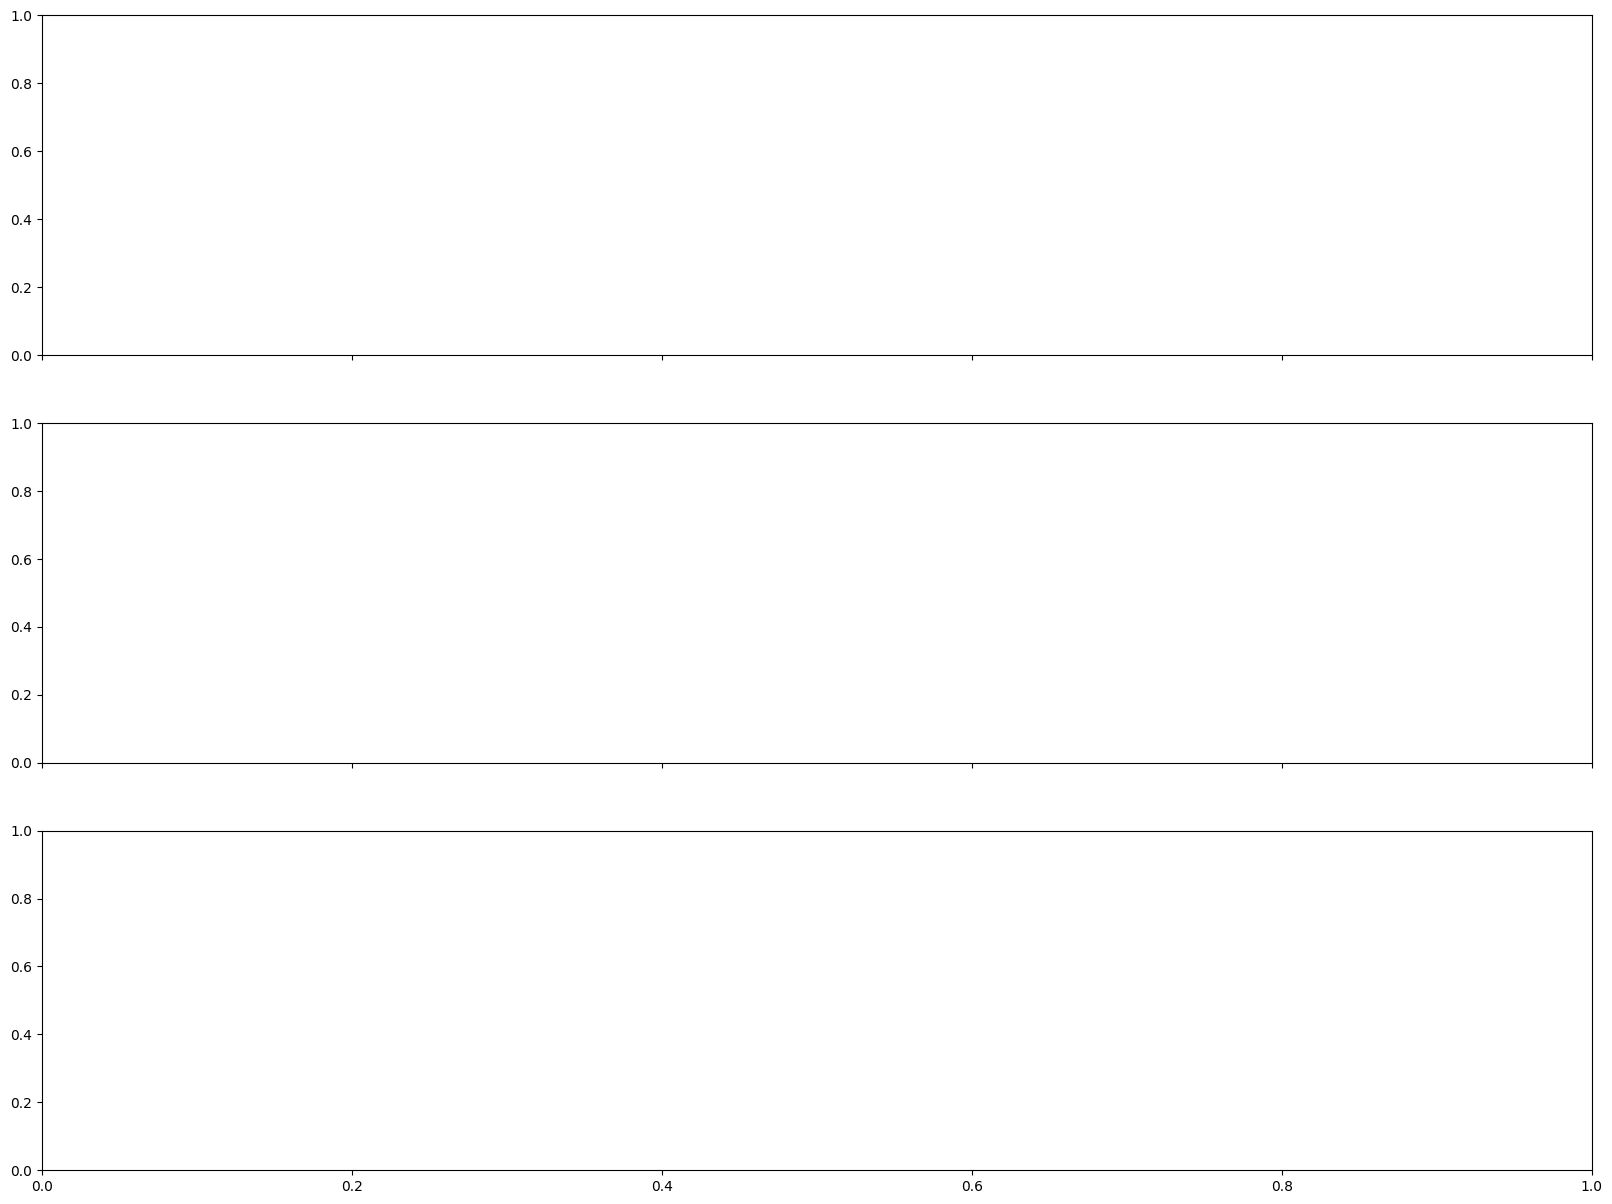

In [11]:
# Noise Integration

num_timeseries = 15
timesteps = 1000
dt = 0.1
times = np.arange(timesteps)

# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

multiple_timeseries = []

for t in range(num_timeseries):
    # Forecast mean using LIM model
    lim_integration, times = model.euler_method(L=model.logarithmic_matrix,
                                             Q=model.noise_covariance,
                                             x0=x_input,
                                             dt=dt,
                                             T=timesteps
                                             )
lim_integration = lim_integration[0, :, :].T
lim_integration = lim_integration[:, 0::10]
print(lim_integration.shape)
multiple_timeseries.append(lim_integration)

mean_timeseries = np.mean(multiple_timeseries, axis=0)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(20, 15), sharex=True)
times = np.arange(timesteps*dt)

for i, component in enumerate(idx_components):

    for t in range(num_timeseries):
        #print("multiple_timeseries[t][component, :]: ", multiple_timeseries[t][component, :])
        axs[i].plot(times[:], multiple_timeseries[t][component, :], color='grey', alpha=0.15)

    # Plot forecasted data using LIM model
    axs[i].plot(times[:], mean_timeseries[component, :], color="blue", label=f'LIM (mean)', linewidth=2.5)

    # Set y-axis label
    axs[i].set_ylabel(f'PC {idx_components[i]+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time (timesteps ~ 1month)')
fig.savefig('./plots/svg/LIM_integration_timeseries_piControl.svg', format='svg')
fig.savefig('./plots/png/LIM_integration_timeseries_piControl.png', format='png')
plt.show()


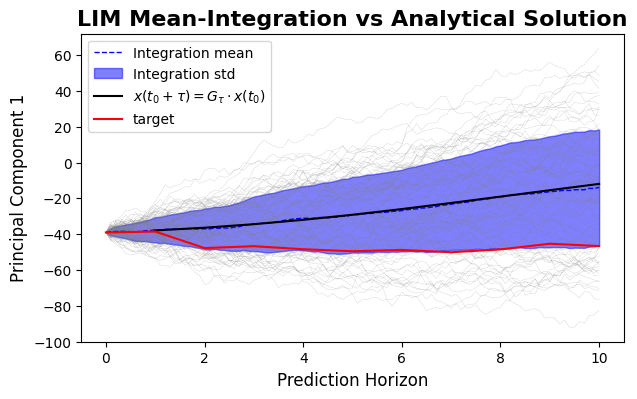

In [17]:
# Ensemble forecast
timesteps = 10
num_samples = 100
dt = 0.1
# Initial condition
time_idx = 0
x_input = data_test.isel(time=time_idx).values
x_target = data_test.isel(time=slice(time_idx, time_idx+timesteps+1))

# Euler integration
lim_integration, times = model.euler_method(L=model.logarithmic_matrix,
                                             Q=model.noise_covariance,
                                             x0=x_input,
                                             dt=dt,
                                             T=timesteps,
                                            num_samples=num_samples
                                             )

# Analytic mean prediction
times_analytic = np.arange(1, timesteps+1)
x_analytic = np.array(
    [np.dot(linalg.expm(model.logarithmic_matrix*t), x_input) for t in times_analytic]
)


n_eof = 0
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# Plot ensemble
ax.plot(times, lim_integration[:, :, n_eof].T, color='grey', lw=0.2, alpha=0.5)
# Plot ensemble mean and std
ax.plot(times, lim_integration[:,:, n_eof].mean(axis=0), '--', color='b', lw=1,
        label=r'Integration mean')
ax.fill_between(times,
                lim_integration[:, :, n_eof].mean(axis=0) - lim_integration[:, :, n_eof].std(axis=0),
                lim_integration[:, :, n_eof].mean(axis=0) + lim_integration[:, :, n_eof].std(axis=0),
                color='b', alpha=0.5, label='Integration std')
# Plot analytic mean
ax.plot(times_analytic, x_analytic[:,n_eof], '-k', label=r'$x(t_0+\tau) = G_{\tau} \cdot x(t_0)$')
# Plot target
ax.plot(np.arange(len(x_target['time'].data)), x_target.isel(eof=n_eof).data, '-r', label='target')

ax.set_xlabel('Prediction Horizon', fontsize=12)
ax.set_ylabel('Principal Component 1', fontsize=12)
ax.legend()
plt.title(f'LIM Mean-Integration vs Analytical Solution', fontsize=16, fontweight='bold')
fig.savefig('./plots/svg/LIM_integration_FINAL.svg', format='svg')
fig.savefig('./plots/png/LIM_integration_FINAL.png', format='png')
plt.savefig('./plots/png/LIM_integration_FINAL.png', format='png')
plt.show()

In [14]:
# Create training and test data

data = pc_20_ts
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]

# original fit
tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)

logar_matr = model.logarithmic_matrix
noise_matr = model.noise_covariance


# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

timesteps = 10000

# Forecast mean using LIM model
lim_integration, times_ = model.euler_method(L=model.logarithmic_matrix,
                                             Q=model.noise_covariance,
                                             x0=x_input,
                                             dt=0.1,
                                             T=timesteps
                                             )
lim_integration = lim_integration[0, :, :].T
lim_integration = lim_integration[:, 0::10]

tau = 1
model2 = LIM_class.LIM(tau)
model2.fit(lim_integration)

logar_matr2 = model2.logarithmic_matrix
noise_matr2 = model2.noise_covariance

Covariance matrix has negative values!
Covariance matrix has negative values!


G_min : [-0.20762843, -0.19669863665455253]
G_max : [0.9794473, 0.9822594915686836]
L_min : [-0.37645993, -0.3731609667037533]
L_max : [0.27539316, 0.27599890556179657]
Q_min : [-8.896204, -8.859735934547626]
Q_max : [49.45722, 49.153011036170305]


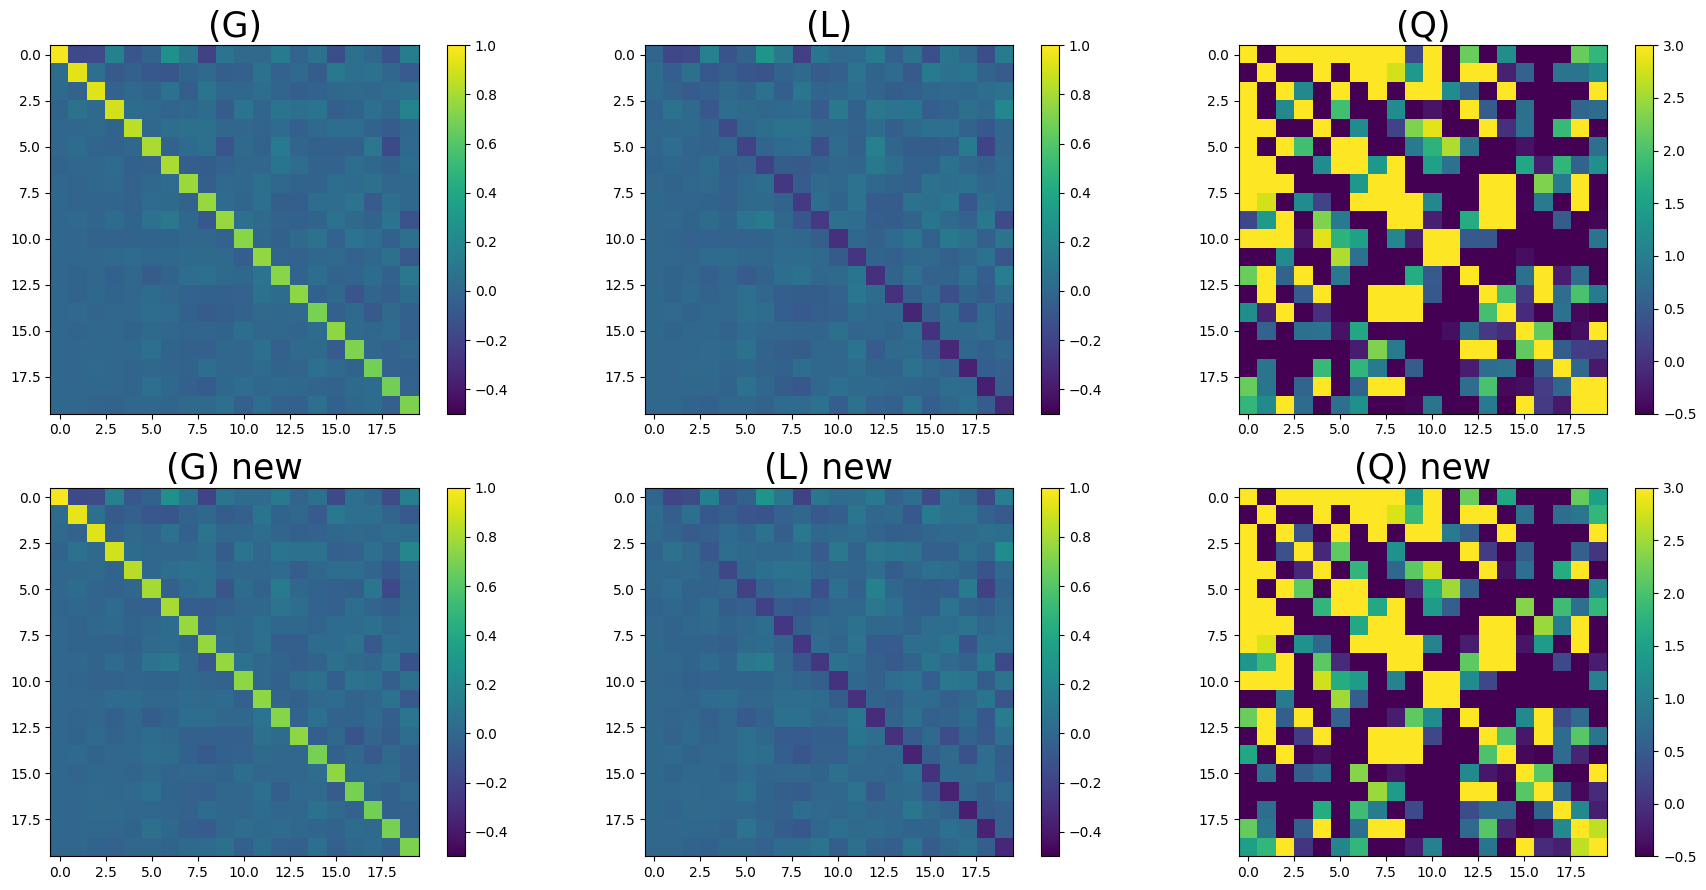

In [15]:
# Plot G, L, Q
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

# Plot G
im1 = axs[0][0].imshow(model.green_function, vmin=-0.5, vmax=1)
#im1 = axs[0][0].imshow(model.green_function)
axs[0][0].set_title('(G)', fontsize=25)
fig.colorbar(im1, ax=axs[0][0])
im11 = axs[1][0].imshow(model2.green_function, vmin=-0.5, vmax=1)
#im11 = axs[1][0].imshow(model2.green_function)
axs[1][0].set_title('(G) new', fontsize=25)
fig.colorbar(im11, ax=axs[1][0])

g_min = [np.min(model.green_function), np.min(model2.green_function)]
g_max = [np.max(model.green_function), np.max(model2.green_function)]
print("G_min : {}".format(g_min))
print("G_max : {}".format(g_max))

# Plot L
im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix), vmin=-0.5, vmax=1)
#im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix))
axs[0][1].set_title('(L)', fontsize=25)
fig.colorbar(im2, ax=axs[0][1])
im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix), vmin=-0.5, vmax=1)
#im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix))
axs[1][1].set_title('(L) new', fontsize=25)
fig.colorbar(im21, ax=axs[1][1])

l_min = [np.min(np.real(model.logarithmic_matrix)), np.min(np.real(model2.logarithmic_matrix))]
l_max = [np.max(np.real(model.logarithmic_matrix)), np.max(np.real(model2.logarithmic_matrix))]
print("L_min : {}".format(l_min))
print("L_max : {}".format(l_max))


# Plot Q
im3 = axs[0][2].imshow(np.real(model.noise_covariance), vmin=-0.5, vmax=3)
#im3 = axs[0][2].imshow(np.real(model.noise_covariance))
axs[0][2].set_title('(Q)', fontsize=25)
fig.colorbar(im3, ax=axs[0][2])
im31 = axs[1][2].imshow(np.real(model2.noise_covariance), vmin=-0.5, vmax=3)
#im31 = axs[1][2].imshow(np.real(model2.noise_covariance))
axs[1][2].set_title('(Q) new', fontsize=25)
fig.colorbar(im31, ax=axs[1][2])

q_min = [np.min(np.real(model.noise_covariance)), np.min(np.real(model2.noise_covariance))]
q_max = [np.max(np.real(model.noise_covariance)), np.max(np.real(model2.noise_covariance))]
print("Q_min : {}".format(q_min))
print("Q_max : {}".format(q_max))

plt.tight_layout()
fig.savefig('./plots/svg/G_Q_L_function_piControl.svg', format='svg')
fig.savefig('./plots/png/G_Q_L_function_piControl.png', format='png')
plt.show()

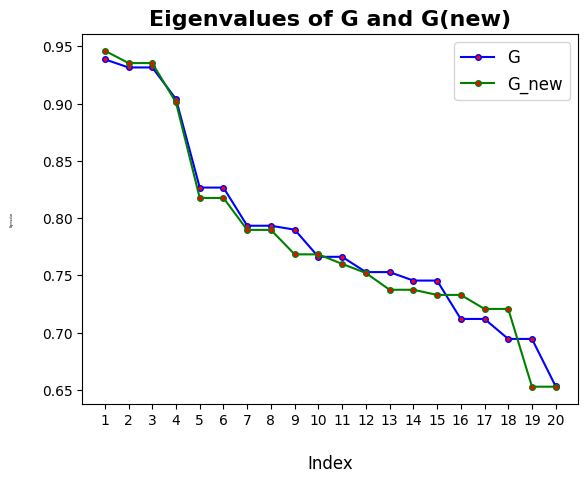

In [19]:
# Plotting eigenvalues of G
eigenvalues, _, w = ut.matrix_decomposition(model.green_function)
eigenvalues2, _, w = ut.matrix_decomposition(model2.green_function)

x = np.arange(1, len(eigenvalues) + 1)

# Plot the eigenvalues
plt.plot(x, eigenvalues, marker='o', linestyle='-', color='b', markersize=4, markerfacecolor='r', linewidth=1.5, label='G')
plt.plot(x, eigenvalues2, marker='o', linestyle='-', color='g', markersize=4, markerfacecolor='r', linewidth=1.5, label='G_new')
# Set the labels and title
plt.xlabel('Index', fontsize=12, labelpad=20)
plt.ylabel('Eigenvalue', fontsize=2, labelpad=20)
plt.title(f'Eigenvalues of G and G(new)', fontsize=16, fontweight='bold')


# Set the x-axis tick labels
plt.xticks(x, fontsize=10)
plt.legend(loc="upper right", fontsize=12)



# Display the plot
plt.savefig('./plots/svg/eigenvalues_G_combined_piControl.svg', format='svg')
plt.savefig('./plots/png/eigenvalues_G_combined_piControl.png', format='png')
plt.show()


In [ ]:
#Plotting G for tau [0...25]

lag_arr = np.arange(1, 24, 1)
growth_arr = []
growth_arr_min = []
growth_arr_max = []
growth_arr_minmax = []

for lag in lag_arr:
    w, U, V = ut.matrix_decomposition(model.green_function)
    G_tau = U @ np.diag(w**(lag/model.tau)) @ np.linalg.inv(U)
    w_tau, U_tau, V_tau = ut.matrix_decomposition(G_tau.T @ G_tau)
    w_tau_min = np.min(w_tau.real)
    w_tau_max = np.max(w_tau.real)
    growth_arr_min.append(w_tau_min)
    growth_arr_max.append(w_tau_max)
    growth_arr.append(w_tau[0])

growth_arr_minmax = [(growth_arr_min[i] + growth_arr_max[i])/2 for i in range(len(growth_arr_min))]

# Plot growth
fig, ax = plt.subplots()
ax.plot(lag_arr, growth_arr_minmax, marker='o', linestyle='-', color='b')
ax.errorbar(lag_arr, growth_arr_minmax, yerr=growth_arr_minmax,
             linestyle='', color='b', capsize=4)
_ = ax.set_xlabel(r"$\tau$", fontsize=18, labelpad=20)
_ = ax.set_ylabel(r"$\gamma$", fontsize=18, labelpad=20)
_ = ax.set_title(rf"Eigenvalues of G for multiple $\tau$", fontsize=16)
ax.grid('y')
plt.savefig('./plots/svg/G_eigenvalues_multiple_tau_piControl.svg', format='svg')
plt.savefig('./plots/png/G_eigenvalues_multiple_tau_piControl.png', format='png')
plt.show()


In [ ]:
import scipy.stats as stats

pc_10 = np.array(pc_20_ts)

# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 9))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    stats.probplot(pc_10[i, :500], dist="norm", plot=axs[i,0])
    axs[i,0].set_title("Q-Q of PC {} initial".format(i + 1), fontsize=20)
    axs[i,0].set_xlabel("Theoretical quantiles", fontsize=20, labelpad=25)
    axs[i,0].set_ylabel("Ordered Values", fontsize=20, labelpad=25)
    axs[i,0].tick_params(axis='both', which='major', labelsize=20)

    stats.probplot(lim_integration[i, :500], dist="norm", plot=axs[i, 1])
    axs[i,1].set_title("Q-Q of PC {} new".format(i + 1), fontsize=20)
    axs[i,1].set_xlabel("Theoretical quantiles", fontsize=20, labelpad=25)
    axs[i,1].set_ylabel("", fontsize=20, labelpad=25)
    axs[i,1].tick_params(axis='both', which='major', labelsize=20)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
plt.savefig('./plots/svg/QQ_plot_PC_seperat_piControl.svg', format='svg')
plt.savefig('./plots/png/QQ_plot_PC_seperat_piControl.png', format='png')
plt.show()



In [ ]:
def generate_timesteps(values, num_timesteps):
    min_value = round(min(values))
    max_value = round(max(values))
    timestep_values = np.linspace(min_value, max_value, num_timesteps, dtype = int)
    return timestep_values.tolist()

def count_values_by_timestep(timesteps, values):
    timestep_counts = []

    # Sort the timesteps in ascending order
    sorted_timesteps = sorted(timesteps)

    # Iterate over each timestep (except the last one)
    for i in range(len(sorted_timesteps)-1):
        count = 0
        # Check if each value falls within the current timestep range
        for value in values:
            if sorted_timesteps[i] <= value < sorted_timesteps[i+1]:
                count += 1
        timestep_counts.append(count)

    # Count the values that fall within the last timestep range
    last_timestep_count = 0
    for value in values:
        if value >= sorted_timesteps[-1]:
            last_timestep_count += 1
    timestep_counts.append(last_timestep_count)
    return timestep_counts



timesteps = generate_timesteps(pc_10[1, :500], 10)
print("Generated timesteps : {}".format(timesteps))

counts = count_values_by_timestep(timesteps, pc_10[1, :500])
print("Timestep counts : {}".format(counts))


plt.bar(timesteps, counts, align='center', width=3)

for i, count in enumerate(counts):
    plt.text(timesteps[i], count, str(count), ha='center', va='bottom', fontsize=15)

plt.ylim(0, (max(counts) + 25))
plt.xlabel('Value-Increments')
plt.ylabel('Counts')
plt.title('Histogram of PC2-values over 10 increments', fontsize=15)

plt.savefig('./plots/svg/pc_data_distribution_piControl.svg', format='svg')
plt.savefig('./plots/png/pc_data_distribution_piControl.png', format='png')
plt.show()